## Modeling Vanilla Interest Rate Swaps

*By Andre Sealy*

Interest Rate Swaps are the most widely traded, liquid, and universal of all over-the-counter (or OTC) derivative contracts. The first swap was traded in 1981, and explosive growth followed in the 1990s and 2000s. The outstanding notional interest swaps grew from approximately 20 trillion dollars in 1995 to 55 trillion dollars in 2000 to 400 trillion dollars as of December 2011 (out of a total $500 trillion interest rate derivative market).

The national numbers are enormous compared to the US GDP of approximately 20 trillion dollars and total worldwide equity market capitalization of approximately 50 trillion dollars. However, the values of interest rate derivatives are typically small fractions of the notional.

Swaps allow institutions to manage their exposure to interest rate movements or to adjust the nature of their interest rate liabilities. Swaps can be a trading tool, allowing a counterparty to 'buy' or 'sell' interest rates and thus profit (or lose) on their movements, or a risk management tool, for example, allowing a counterparty to replace unknown floating cashflows with a fixed stream.

### Swap Definition

A ***swap*** is an arrangement between two counterparties to exchange a series of cashflows at agreed dates. Cashflows are calculated on a notional amount, which we will typically take to be 1. A swap has a start date $T_{0}$, maturity $T_{n}$, and payment dates $T_{i}$, $i=1, \ldots, n$.

The payment frequency for the floating and fixed legs may differ, but we will assume here they are same.

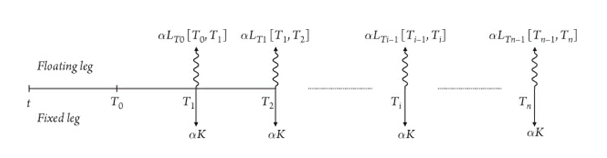

The swap shown graphically above demonstrates In a standard or *vanilla* swap we typically have $T_{i+1}=T_{i}+\alpha$ for a fixed $\alpha$. In practice, $\alpha$ may differ slightly for each period (for example, 92/365 or 91/365 instead of 0.25) and should precisely be written $\alpha_{i}$, but we will assume constant $\alpha$ for simplicity.

The ***floating leg*** of the swap consists of payments $\alpha L_{T_{i}}[T_{i},T_{i}+\alpha ]$ at $T_{i} + \alpha$, that is, libor fixing at $T_{i}$ for the period $T_{i}$ to $T_{i} + \alpha$, paid at $T_{i} + \alpha$.

The ***fixed leg*** of the swap consists of payments $\alpha K$ at $T_{i}+\alpha$, that is, a fixed rate $K$ accrued from $T_{i}$ to $T_{i} + \alpha$, paid at $T_{i}+\alpha$.

### Forward Swap Rate and Swap Value

The value of the fixed leg is given by

$$V_{K}^{FXD}(t)=K\sum_{i=1}^{n}\alpha Z(t, T_{i})=KP_{t}[T_{0},T_{n}]$$

The fixed leg of the swap has the present value of an annuity paying $K$ times accural factor $\alpha$ at each payment date. The term $P_{t}[T_{0},T_{n}]$ is called the $pv01$ of the swap, the present value of receieving 1 times $\alpha$ at each payment date. (Our notation for the value of the swap leg for simplicity suppresses information about the dates of the underlying swap.)

Since the floating leg is a series of regular libor payments, we can value it by replacing each libor with its forward. Thus, the value of the floating leg is

$$V^{FL}(t)=\sum_{i=1}^{n}L_{t}[T_{i-1},T_{i}]\alpha Z(t_{i},T_{i}) = \sum_{i=1}^{n}(Z(t_{i},T_{i-1})-Z(t_{i},T_{t}))=Z(t,T_{0})-Z(t,T_{n}),$$

where the difference between two zero coupon bond prices, being the value receiving 1 at the beginning of the swap and paying 1 at its end.

Therefore, we have the intuitively appealing result that the value of receiving LIBOR payments on one dollar is equal to the value of receiving one dollar at the beginning of the stream and giving it back at the end. We can simply take the dollar and repeatedly invest in a series of libor deposits.

The ***foward swap rate*** at time $t$ for a swap from $T_{0}$ to $T_{n}$ is defined to be the value $y_{t}[T_{0},T_{n}]$ of the fixed rate $K$ such that the value of the swap at $t$ is zero.

$$y_{t}[T_{0},T_{n}]=\frac{\sum_{i=1}^{n}L_{t}[T_{i-1},T_{i}]\alpha Z(t_{i},T_{i})}{\sum_{i=1}^{n}\alpha Z(t_{i},T_{i})}=\frac{Z(t,T_{0})-Z(t, T_{n})}{P_{t}[T_{0},T_{n}]}$$

The forward swap rate is thus a weighted average of forward libors, which collapses to a ratio of a linear combination of ZCB prices to the pv01 (itself a linear combination of ZCB prices).

## Example

This example will involve a plain vanilla USD swap with a 10 million notional amount and a10 year maturity. Let the fixed leg pay 2.5\% coupon semiannually, and the floating leg pay LIBOR 3M quarterly.

For this exercise, we will be using the `QuantLib` module.

In [1]:
import QuantLib as ql
calculation_date = ql.Date(30, 12, 2020)
ql.Settings.instance().evaluationDate = calculation_date

Here, we construct the yield curve objects. For simplicity, we will use flat yield curves for discounting and LIBOR 3M. This will help us focus on the constuctuion of the Swap. The term structure of a fixed income asset is pivotal for pricing securities. We would need the `YieldTermStructure` method from the `QuantLib` module to use with the pricing engines.


In [2]:
# constructing the discount curve and libor curve

risk_free_rate = 0.01
libor_rate = 0.02
day_count = ql.Actual365Fixed()

discount_curve = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)

libor_curve = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, libor_rate, day_count)
)

#libor3M_index = ql.Euribor3M(libor_curve)
libor3M_index = ql.USDLibor(ql.Period(3, ql.Months), libor_curve)

To construct the Swap instrument, we have to specify the fixed rate leg and floating rate leg. We construct the fixed rate and floating rate leg schedules below.

In [3]:
calendar = ql.UnitedStates()
settle_date = calendar.advance(calculation_date, 5, ql.Days)
maturity_date = calendar.advance(settle_date, 10, ql.Years)

fixed_leg_tenor = ql.Period(6, ql.Months)
fixed_schedule = ql.Schedule(settle_date, maturity_date,
                            fixed_leg_tenor, calendar,
                            ql.ModifiedFollowing, ql.ModifiedFollowing,
                            ql.DateGeneration.Forward, False)

float_leg_tenor = ql.Period(3, ql.Months)
float_schedule = ql.Schedule(settle_date, maturity_date,
                            float_leg_tenor, calendar,
                            ql.ModifiedFollowing, ql.ModifiedFollowing,
                            ql.DateGeneration.Forward, False)

Below, we construct a Vanilla Swap object including the fixed and float leg schedules created above.

In [4]:
notional = 10000000
fixed_rate = 0.025
fixed_leg_daycount = ql.Actual360()
float_spread = 0.004
float_leg_daycount = ql.Actual360()

ir_swap = ql.VanillaSwap(ql.VanillaSwap.Payer, notional, fixed_schedule,
                        fixed_rate, fixed_leg_daycount, float_schedule,
                        libor3M_index, float_spread, float_leg_daycount)

Now, we evaluate the swap using a discounting engine.

In [5]:
swap_engine = ql.DiscountingSwapEngine(discount_curve)
ir_swap.setPricingEngine(swap_engine)

The code chunk provides the cashflows for the fixed and floating leg, which can be extracted from the `ir_swap` object. The fixed leg cashflows are shown below:

In [6]:
for i, cf in enumerate(ir_swap.leg(0)):
    print("%2d   %-18s   %10.2f"%(i+1, cf.date(), cf.amount()))

 1   July 7th, 2021        125694.44
 2   January 7th, 2022     127777.78
 3   July 7th, 2022        125694.44
 4   January 9th, 2023     129166.67
 5   July 7th, 2023        124305.56
 6   January 8th, 2024     128472.22
 7   July 8th, 2024        126388.89
 8   January 7th, 2025     127083.33
 9   July 7th, 2025        125694.44
10   January 7th, 2026     127777.78
11   July 7th, 2026        125694.44
12   January 7th, 2027     127777.78
13   July 7th, 2027        125694.44
14   January 7th, 2028     127777.78
15   July 7th, 2028        126388.89
16   January 8th, 2029     128472.22
17   July 9th, 2029        126388.89
18   January 7th, 2030     126388.89
19   July 8th, 2030        126388.89
20   January 7th, 2031     127083.33


The floating leg cashflows are shown below:

In [7]:
for i, cf in enumerate(ir_swap.leg(1)):
    print("%2d   %-18s   %10.2f"%(i+1, cf.date(), cf.amount()))

 1   April 7th, 2021        59436.87
 2   July 7th, 2021         60098.65
 3   October 7th, 2021      60760.46
 4   January 7th, 2022      60760.46
 5   April 7th, 2022        59436.87
 6   July 7th, 2022         60098.65
 7   October 7th, 2022      60760.46
 8   January 9th, 2023      62084.17
 9   April 7th, 2023        58118.70
10   July 7th, 2023         60093.17
11   October 10th, 2023     62746.07
12   January 8th, 2024      59436.87
13   April 8th, 2024        60098.65
14   July 8th, 2024         60098.65
15   October 7th, 2024      60098.65
16   January 7th, 2025      60760.46
17   April 7th, 2025        59436.87
18   July 7th, 2025         60098.65
19   October 7th, 2025      60760.46
20   January 7th, 2026      60760.46
21   April 7th, 2026        59436.87
22   July 7th, 2026         60098.65
23   October 7th, 2026      60760.46
24   January 7th, 2027      60760.46
25   April 7th, 2027        59436.87
26   July 7th, 2027         60098.65
27   October 7th, 2027      60760.46
2

Finally, we will print other important analytics such as the fair value, fair spread, and BPS for the Fixed and Floating legs.

In [8]:
print("%-20s: %20.3f" % ("Net Present Value", ir_swap.NPV()))
print("%-20s: %20.3f" % ("Fair Spread", ir_swap.fairSpread()))
print("%-20s: %20.3f" % ("Fair Rate", ir_swap.fairRate()))
print("%-20s: %20.3f" % ("Fixed Leg BPS", ir_swap.fixedLegBPS()))
print("%-20s: %20.3f" % ("Floating Leg BPS", ir_swap.floatingLegBPS()))

Net Present Value   :          -115022.955
Fair Spread         :                0.005
Fair Rate           :                0.024
Fixed Leg BPS       :            -9627.216
Floating Leg BPS    :             9639.272
